Setup

In [57]:
import torch
from torch import nn, autograd
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import glob

In [58]:
!pip install pytorch-fid

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Settings

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Running on {device}')

Running on cuda


In [61]:
#Adjustable Parameters
bs = 10             # batch size
d_ratio = 20        # number of discriminator steps for every generator step
lambda_gp = 10      # default gradient penalty for WGAN-GP

Data Processing

In [62]:
mnist_data = torchvision.datasets.MNIST('MNIST',download=True,transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [63]:
target_dataloader = DataLoader(mnist_data, batch_size=bs, shuffle=True)

Model

In [64]:
def get_noise(n=None):
  if not n:
    n = bs
  return torch.rand(n,8,4,4).to(device)

In [65]:
class Upsample_block(nn.Module):
  """
  Increases the size of the "image" by a factor of 2
  """
  def __init__(self,chan_in,chan_out):
    super().__init__()
    self.model = nn.Sequential(
        nn.ConvTranspose2d(chan_in,chan_out,3,stride=2,padding=1,output_padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(chan_out),
        nn.Conv2d(chan_out,chan_out,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(chan_out),
        nn.Conv2d(chan_out,chan_out,3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(chan_out)
    )
  def forward(self,X):
    return self.model(X)

In [66]:
class Generator(nn.Module):
  def __init__(self, upsample_block):
    super().__init__()
    self.model = nn.Sequential(
      upsample_block(8,64), # 4 --> 8
      upsample_block(64,32), # 8 --> 16
    )
    self.final_block = nn.Sequential(
      nn.ConvTranspose2d(32,8,3,stride=2,padding=3,output_padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      nn.Conv2d(8,1,3,padding=1),
    )
    self.sigmoid = nn.Sigmoid()

  def forward(self,Z):
    out = self.model(Z)
    out = self.final_block(out)
    out = self.sigmoid(out)
    return out

In [67]:
class Downsample_block(nn.Module):
  """
  Decreases the size of the "image" by a factor of 2
  """
  def __init__(self, chan_in, chan_out):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(chan_in, chan_out,3,stride=2,padding=1),
        nn.LeakyReLU()
    )
  def forward(self,X):

    return self.model(X)

In [68]:
class Discriminator(nn.Module):
  def __init__(self, downsample_block):
    super().__init__()
    self.model = nn.Sequential(
      downsample_block(1,16), # 28 --> 14
      downsample_block(16,32), # 14 --> 7
      downsample_block(32,16), # 7 --> 4
      downsample_block(16,8), # 4 --> 2
      downsample_block(8,1), # 2 --> 1
      nn.Sigmoid()
    )

  def forward(self,X):
    out = self.model(X)
    return out.squeeze()

In [69]:
def compute_gp(D, real_data, fake_data):
  """
  Computes the Gradient Penalty for the WGAN
  Original paper: https://arxiv.org/abs/1704.00028 
  """
  eps = torch.rand(bs, 1, 1, 1).to(device)
  eps = eps.expand_as(real_data)
  interpolation = eps * real_data + (1 - eps) * fake_data
  interp_logits = D(interpolation)
  grad_outputs = torch.ones_like(interp_logits)
  gradients = autograd.grad(
      outputs=interp_logits,
      inputs=interpolation,
      grad_outputs=grad_outputs,
      create_graph=True,
      retain_graph=True,
  )[0]
  gradients = gradients.view(bs, -1)
  grad_norm = gradients.norm(2, 1)
  return torch.mean((grad_norm - 1) ** 2)

Training

In [70]:
G = Generator(Upsample_block).to(device)
D = Discriminator(Downsample_block).to(device)

In [71]:
#OPTIONAL - Load existing weights to continue training
G = torch.load('/content/drive/MyDrive/Colab Notebooks/MNIST GAN/Generator Weights', map_location=torch.device(device))
D = torch.load('/content/drive/MyDrive/Colab Notebooks/MNIST GAN/Discriminator Weights', map_location=torch.device(device))

In [72]:
G_optimiser = torch.optim.Adam(G.parameters())
D_optimiser = torch.optim.Adam(D.parameters())

In [73]:
def train_generator(G,D,G_optimiser):
  Z = get_noise()
  loss = -torch.mean(D(G(Z)))
  G_optimiser.zero_grad()
  loss.backward()
  G_optimiser.step()

In [74]:
def train_discriminator(X,G,D,D_optimiser):
  """
  Implementation of WGAN
  Original paper: https://arxiv.org/abs/1701.07875 
  """
  X = X.to(device)
  Z = get_noise()
  fakes = G(Z)
  gp = compute_gp(D, X, fakes)
  loss = -torch.mean(D(X)) + torch.mean(D(fakes)) + lambda_gp * gp
  D_optimiser.zero_grad()
  loss.backward()
  D_optimiser.step()

In [81]:
#Main Training Loop - approx 90s per epoch

EPOCHS = 20

progress_images = []
for epoch in tqdm(range(EPOCHS)):
  for i in range(len(target_dataloader)):
    X,_ = next(iter(target_dataloader))
    train_discriminator(X,G,D,D_optimiser)
    if i % d_ratio == 0:
      train_generator(G,D,G_optimiser)
  Z = get_noise(n=1)
  progress_images.append(G(Z).cpu())
    

100%|██████████| 20/20 [30:24<00:00, 91.23s/it]


Generate Fakes, Save and Test FID Score

In [90]:
def show_progression(images):
  n = len(images)
  fig = plt.figure(figsize=(9,9*n))
  rows,cols = 1,n
  for i in range(1,rows*cols+1):
    img = images[i-1].squeeze().detach().numpy()
    fig.add_subplot(rows,cols,i)
    plt.imshow(img,cmap="gray")
    plt.axis("off")
  plt.show()

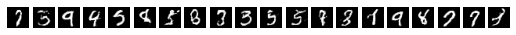

In [91]:
show_progression(progress_images)

In [76]:
def generate_fakes(number):
  Z = get_noise(n=number)
  fakes = G(Z).cpu()
  return fakes

In [77]:
def generate_reals(number):
  reals = []
  for i in range(number):
    idx = torch.randint(len(mnist_data),(1,)).item()
    img = mnist_data[i][0]
    reals.append(img)
  return reals

In [84]:
def show_sample(images,size):
  fig = plt.figure(figsize=(9,9))
  rows,cols = size
  for i in range(1,rows*cols+1):
    idx = torch.randint(len(images),(1,)).item()
    img = images[idx].squeeze().detach().numpy()
    fig.add_subplot(rows,cols,i)
    plt.imshow(img,cmap="gray")
    plt.axis("off")
  plt.show()

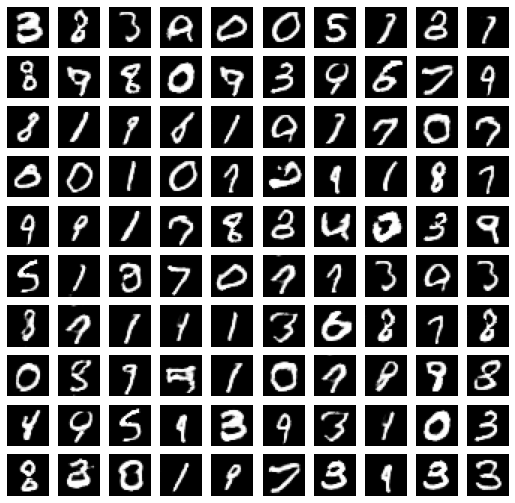

In [87]:
fakes = generate_fakes(100)
show_sample(fakes,(10,10))

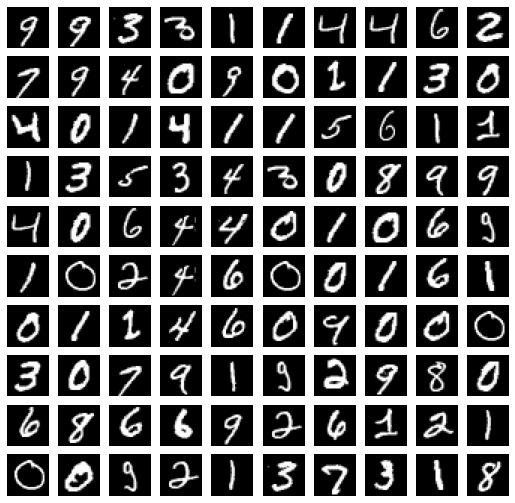

In [86]:
show_sample(generate_reals(100),(10,10))

Frechet Inception Distance (FID)

In [79]:
def save_real_sample(data):
  os.chdir("/content/drive/MyDrive/Colab Notebooks/MNIST GAN/Real_Sample")
  for i in tqdm(range(100)):
    idx = torch.randint(len(data),(1,)).item()
    img = data[i][0]
    img_name = f'real-image-{i+1}.png'
    save_image(img,img_name)

In [80]:
def save_fake_sample(images):
  os.chdir("/content/drive/MyDrive/Colab Notebooks/MNIST GAN/Fake_Sample")
  for i in tqdm(range(len(images))):
    img = images[i].squeeze(0).detach()
    img_name = f'fake-image-{i+1}.png'
    save_image(img,img_name)

In [ ]:
if len(os.listdir("/content/drive/MyDrive/Colab Notebooks/MNIST GAN/Real_Sample")) == 0:
  save_real_sample(mnist_data)
os.chdir("/content/drive/MyDrive/Colab Notebooks/MNIST GAN/Fake_Sample")
if len(os.listdir("/content/drive/MyDrive/Colab Notebooks/MNIST GAN/Real_Sample")) > 0:
  old_fakes = glob.glob('/content/drive/MyDrive/Colab Notebooks/MNIST GAN/Fake_Sample/*')
  for f in old_fakes:
      os.remove(f)
save_fake_sample(fakes)

100%|██████████| 100/100 [00:00<00:00, 168.88it/s]


In [ ]:
"""
  Implementation of the Frechet Inception Distance (FID) - metric for GANs.
  source: https://github.com/mseitzer/pytorch-fid 
  Original paper here: https://arxiv.org/abs/1706.08500
"""
!python -m pytorch_fid '/content/drive/MyDrive/Colab Notebooks/MNIST GAN/Real_Sample' '/content/drive/MyDrive/Colab Notebooks/MNIST GAN/Fake_Sample'

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:06<00:00, 14.1MB/s]
100% 2/2 [00:00<00:00,  2.65it/s]
100% 2/2 [00:00<00:00,  3.16it/s]
FID:  57.623540733601004


Save Model Weights

In [92]:
torch.save(G,'/content/drive/MyDrive/Colab Notebooks/MNIST GAN/Generator Weights')

In [93]:
torch.save(D,'/content/drive/MyDrive/Colab Notebooks/MNIST GAN/Discriminator Weights')